In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import poligrain as plg

In [63]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #suppress warnings in functions or not?

## Preparing the data sets

So far this notebook only covers the comparison between CML and radar. <br>
*Note: the functions should in principle be able to handle validation with another (point based) sensor too, provided that the data has been correctly coupled to the CML data before hand.*

### Load CML and radar data
Following the example from [`Get_grid_at_lines_and_points.ipynb`](https://github.com/OpenSenseAction/poligrain/blob/main/docs/notebooks/Get_grid_at_lines_and_points.ipynb), we use CML data that has already been processed to include path-averaged rainfall rate (see how that is done [here](https://github.com/OpenSenseAction/merging_prototype/blob/9cd018be263a8f5ae38bb28c1f768b353d97ffbc/radar_cml_gauge_merge_prototype.ipynb)).  

In [34]:
# Load datasets
ds_cmls = xr.open_dataset("data/openMRG_cmls_20150827_12hours.nc")
ds_radar = xr.open_dataset("data/openMRG_example_rad_20150827_90minutes.nc")

### Resample CML data

The radar data is in 5 minute intervals, and the CML data in 1 minute intervals, so we resample the CML data to 5 minutes. <br>
*Double check: Here we assume the original 10s CML data was resampled using the right timestamp as handle.* 

Both CML and radar rainfall rate are already in mm/hr, so need to do any transformation here. 

In [35]:
ds_cmls_5m = ds_cmls.R.resample(time="5min", label="right").mean()

### Get one radar value for each CML value
We want to compare the radar estimates along the line with the CML based rainfall estimates on a point to point basis. We therefore need to make sure that we use the same time period. 



In [36]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar,
    ds_line_data=ds_cmls_5m,
)

In [37]:
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_radar.rainfall)

ds_cmls_5m = ds_cmls_5m.where(ds_cmls_5m.time.isin(radar_along_cml.time), drop=True)

Then we need to make sure that for each sub-link, there is a radar rainfall estimate to compare to. I.e. two CML rainfall estimates per single radar estimate. Note that these should not be much different since they cover the same path, but at slighlty different frequencies. 

Finally, for this data set each sublink item has shape cml_id\*time (364\*19) whereas the radar\_along\_cml data has shape (19\*364), so we transpose the radar data.

In [38]:
sublink_0 = ds_cmls_5m.isel(sublink_id=0)
sublink_1 = ds_cmls_5m.isel(sublink_id=1)

cmls_flattened = np.concatenate(
    [sublink_0.values.flatten(), sublink_1.values.flatten()]
)

radar_flattened = np.tile(radar_along_cml.values.T.flatten(), 2)

## Visualize the validation

First we set a threshold. This can be the same or different for the reference and estimated rainfall intensities.  


In [7]:
threshold = 0.0  # mm/h

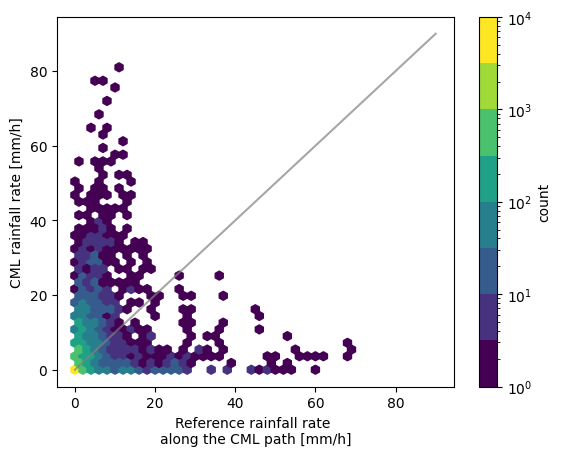

In [8]:
fig, ax = plt.subplots()
hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thr=threshold,
    est_thr=threshold,
    ax=ax,)


If needed we can adapt the layout of the plot, such as the colorscheme and the labels. 

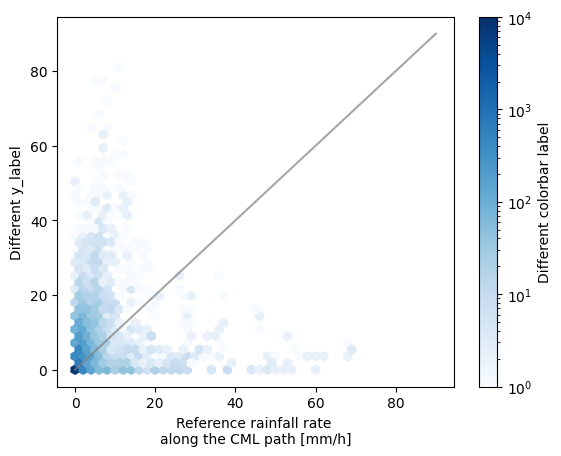

In [17]:
fig, ax = plt.subplots()
hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thr=threshold,
    est_thr=threshold,
    ax=ax,)

ax.set_ylabel("Different y_label")

# change colormap and label
hx.set_cmap('Blues')
hx.colorbar.set_label("Different colorbar label")

## Calculate validation metrics
[Tbd] In the function include an assert statement to check for similar shape as in [pycomlink](https://github.com/pycomlink/pycomlink/blob/master/pycomlink/validation/stats.py)


In [104]:
rainfall_metrics = plg.validation.calculate_rainfall_metrics(reference=radar_flattened, 
                                          estimate=cmls_flattened,
                                          ref_thr=threshold,
                                          est_thr=threshold)

In [105]:
rainfall_metrics

{'reference_rainfall_threshold': 0.1,
 'estimates_rainfall_threshold': 0.1,
 'pearson_correlation_coefficient': 0.18600856728296308,
 'coefficient_of_variation': 3.291406910927754,
 'root_mean_square_error': 8.495855620729753,
 'mean_absolute_error': 4.293080410479576,
 'percent_bias': 66.6742080423337,
 'mean_rainfall_rate_ref': 2.529839200952738,
 'mean_rainfall_rate_est': 4.216589452932479,
 'false_wet_ratio': 1.0,
 'missed_wet_ratio': 0.36063280241067586,
 'false_wet_rainfall_rate': 1.5493810082063306,
 'missed_wet_rainfall_rate': 1.374375452607366,
 'N_all': 13832,
 'N_nan': 380}

In [61]:
radar_wetdry = radar_flattened >= threshold
cmls_wetdry = cmls_flattened >= threshold

wet_dry_metrics = plg.validation.calculate_wet_dry_metrics(reference=radar_wetdry, 
                                                           estimate=cmls_wetdry)

AssertionError: 

In [130]:
    ref_array = np.array([1, 1, 0, 0, 0.1, 0.01, 0, 0, 1, np.nan, 0, np.nan])
    est_array = np.array([0, 1, 1, 0, 0, 1, 0.1, 0, np.nan, np.nan, np.nan, 1])

In [135]:
np.where(np.isnan(ref_array), ref_array, np.where(ref_array >= 0.1, ref_array, 0))

array([1. , 1. , 0. , 0. , 0.1, 0. , 0. , 0. , 1. , nan, 0. , nan])

In [125]:
plg.validation.calculate_rainfall_metrics(reference=ref_array, estimate=est_array, ref_thr=0.1, est_thr=0.1)

{'reference_rainfall_threshold': 0.1,
 'estimates_rainfall_threshold': 0.1,
 'pearson_correlation_coefficient': -0.05998838905420167,
 'coefficient_of_variation': 1.9552563349634617,
 'root_mean_square_error': 0.7071185662013597,
 'mean_absolute_error': 0.5316666666666666,
 'percent_bias': 46.91943127962086,
 'mean_rainfall_rate_ref': 0.3516666666666666,
 'mean_rainfall_rate_est': 0.5166666666666667,
 'false_wet_ratio': 1.0,
 'missed_wet_ratio': 0.6666666666666666,
 'false_wet_rainfall_rate': 0.7000000000000001,
 'missed_wet_rainfall_rate': 0.55,
 'N_all': 12,
 'N_nan': 4,
 'N_nan_reference': 2,
 'N_nan_estimate': 3}

In [116]:
metrics

{'reference_rainfall_threshold': 0.0,
 'estimates_rainfall_threshold': 0.0,
 'pearson_correlation_coefficient': 0.7999999999999998,
 'coefficient_of_variation': 0.5656854249492379,
 'root_mean_square_error': 0.3333333333333333,
 'mean_absolute_error': 0.1111111111111111,
 'percent_bias': -20.0,
 'mean_rainfall_rate_ref': 0.5555555555555556,
 'mean_rainfall_rate_est': 0.4444444444444444,
 'false_wet_ratio': nan,
 'missed_wet_ratio': 0.0,
 'false_wet_rainfall_rate': nan,
 'missed_wet_rainfall_rate': nan,
 'N_all': 12,
 'N_nan': 3,
 'N_nan_reference': 1,
 'N_nan_estimate': 2}

In [118]:
    ref_array = np.array([1, 1, 0, 0, 0.1, 0.01, 0, 0, 1, np.nan, np.nan, ])
    est_array = np.array([0, 1, 1, 0, 0, 1, 0.1, 0, np.nan, np.nan, np.nan, 1])

    metrics = plg.validation.calculate_rainfall_metrics(ref_array, est_array)
    
    assert metrics["reference_rainfall_threshold"] == 0.0
    assert metrics["estimates_rainfall_threshold"] == 0.0
    assert np.isclose(metrics["pearson_correlation_coefficient"], 0.7999, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["coefficient_of_variation"], 0.5656, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["root_mean_square_error"], 0.333, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["mean_absolute_error"], 0.111, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["percent_bias"], -20.0, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["mean_rainfall_rate_ref"], 0.555, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["mean_rainfall_rate_est"], 0.444, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["false_wet_ratio"], np.nan, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["missed_wet_ratio"], 0.0, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["false_wet_rainfall_rate"], np.nan, atol=0.001, equal_nan=True)
    assert np.isclose(metrics["missed_wet_rainfall_rate"], np.nan, atol=0.001, equal_nan=True)
    assert metrics["N_all"] == 12
    assert metrics["N_nan"] == 3
    assert metrics["N_nan_reference"] == 1
    assert metrics["N_nan_estimate"] == 2

c:\Users\baswalraven\Miniconda3\envs\poetry_env\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\baswalraven\Miniconda3\envs\poetry_env\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\baswalraven\OneDrive - Delft University of Technology\Documents\OpenSense\WG2\poligrain\src\poligrain\validation.py:161: RuntimeWarning: divide by zero encountered in scalar divide
  
C:\Users\baswalraven\OneDrive - Delft University of Technology\Documents\OpenSense\WG2\poligrain\src\poligrain\validation.py:164: RuntimeWarning: divide by zero encountered in scalar divide
  coefficient_of_variation = np.std(estimate - reference) / np.mean(reference)


In [66]:
    thresh_idx = (reference >= 3) | (estimate >= 3)
    reference = reference[thresh_idx]
    estimate = estimate[thresh_idx]


    assert reference.shape == estimate.shape


    # metrics: r, CV, RMSE, MAE, PBIAS
    pearson_correlation = np.corrcoef(reference, estimate)
    coefficient_of_variation = np.std(estimate - reference) / np.mean(reference)
    root_mean_square_error = np.sqrt(np.mean((estimate - reference) ** 2))
    mean_absolute_error = np.mean(np.abs(estimate - reference))
    percent_bias = (np.mean(estimate - reference) / np.mean(reference)) * 100  # %

In [67]:
percent_bias

0.0

### Print pretty table with verification metrics
- *In the function perhaps remove the units incase users compare mm. Optionally ask the user to input units.* 

In [36]:
rainfall_metrics

{'Reference_rainfall_threshold': 0.0,
 'Estimates_rainfall_threshold': 0.0,
 'Pearson_correlation coefficient': 0.23422219561134375,
 'Coefficient_of_variation': 3.799162307675764,
 'Root_mean_square_error': 7.378041163267038,
 'Mean_absolute_error': 3.243110959863838,
 'Percent_bias': 66.25412549819958,
 'Mean_rainfall_rate_ref': 1.913144157345106,
 'Mean_rainfall_rate_est': 3.1806810883140053,
 'false_wet_ratio': 0.0,
 'missed_wet_ratio': 0.0,
 'false_wet_rainfall_rate': 0.0,
 'missed_wet_rainfall_rate': 0.0,
 'N_all': 13832,
 'N_nan': 380}

In [155]:
wet_dry_metrics

{'matthews_correlation_coefficient': nan,
 'true_wet_ratio': nan,
 'true_dry_ratio': nan,
 'false_wet_ratio': nan,
 'missed_wet_ratio': nan,
 'N_dry_reference': 0,
 'N_wet_reference': 0,
 'N_true_wet': 0,
 'N_true_dry': 0,
 'N_false_wet': 0,
 'N_missed_wet': 0}

In [ ]:
plg.validation.print_metrics_table(wet_dry_metrics)

In [163]:
metrics_lookup_table = {
    "reference_rainfall_threshold": ("Reference rainfall threshold", rainfall_metrics['reference_rainfall_threshold'], "[mm/h]"),
    "estimates_rainfall_threshold": ("Estimates rainfall threshold", rainfall_metrics['estimates_rainfall_threshold'], "[mm/h]"),
    # " ": (" ", " ", " "),
    "pearson_correlation_coefficient": ("Pearson correlation coefficient", np.round(rainfall_metrics["pearson_correlation_coefficient"], 3), "[-]"),
    "coefficient_of_variation": ("Coefficient of variation", np.round(rainfall_metrics["coefficient_of_variation"], 3), "[-]"),
    "root_mean_square_error": ("Root mean square error", np.round(rainfall_metrics["root_mean_square_error"], 3), "[mm/h]"),
    "mean_absolute_error": ("Mean absolute error", np.round(rainfall_metrics["mean_absolute_error"], 3), "[mm/h]"),
    "percent_bias": ("Percent bias", np.round(rainfall_metrics["percent_bias"], 3), "[%]"),
    # "  ": (" ", " ", " "),
    "mean_rainfall_rate_ref": ("Mean reference rainfall rate ", np.round(rainfall_metrics["mean_rainfall_rate_ref"], 2), "[mm/h]"),
    "mean_rainfall_rate_est": ("Mean estimated rainfall rate", np.round(rainfall_metrics["mean_rainfall_rate_est"], 2), "[mm/h]"),
    "false_wet_ratio": ("False wet ratio", np.round(rainfall_metrics["false_wet_ratio"], 2), "[-]"),
    "missed_wet_ratio": ("Missed wet ratio", np.round(rainfall_metrics["missed_wet_ratio"], 2), "[-]"),
    "false_wet_rainfall_rate": ("False wet rainfall rate", np.round(rainfall_metrics["false_wet_rainfall_rate"], 2), "[mm/h]"),
    "missed_wet_rainfall_rate": ("Missed wet rainfall rate", np.round(rainfall_metrics["missed_wet_rainfall_rate"], 2), "[mm/h]"),
    # "   ": (" ", " ", " "),
    "N_all": ("Total data points", rainfall_metrics["N_all"], "[-]"),
    "N_nan": ("Missing data points", rainfall_metrics["N_nan"], "[-]"),

}

In [ ]:
def print_metrics_table_from_lookup_table(metrics):
    # Calculate the width for the metric column
    max_metric_length = max(len(name[0]) for name in metrics.values())
    metric_column_width = max_metric_length + 2  # Add padding for readability
    value_column_width = 15  # Fixed width for the value column
    unit_column_width = 10   # Fixed width for unit column

    # Create the table header
    table_lines = []
    separator = f"+{'-' * metric_column_width}+{'-' * value_column_width}+{'-' * unit_column_width}+"
    header = (
        f"| {'Metric'.center(metric_column_width-1)}"
        f"| {'Value'.center(value_column_width-1)}"
        f"| {'Units'.center(unit_column_width-1)}|"
    )
    double_separator = f"+{'=' * metric_column_width}+{'=' * value_column_width}+{'=' * unit_column_width}+"


    table_lines.append("Verification metrics:")
    table_lines.append("")
    table_lines.append(double_separator)
    table_lines.append(header)
    table_lines.append(double_separator)

    # Add metrics to the table
    for val in metrics.values():
        row = (
            f"| {val[0].ljust(metric_column_width-1)}"
            f"| {f'{val[1]}'.center(value_column_width - 1)}|"
            f" {val[2].center(unit_column_width-1)}|"
        )
        table_lines.append(row)
        table_lines.append(separator)
    
    return "\n".join(table_lines)

print(print_metrics_table_from_lookup_table(metrics_lookup_table))


Verification metrics:

+=================================+===============+==========+
|              Metric             |     Value     |   Units  |
+=================================+===============+==========+
| Reference rainfall threshold    |      0.1      |
+---------------------------------+---------------+----------+
| Estimates rainfall threshold    |      0.1      |
+---------------------------------+---------------+----------+
| Pearson correlation coefficient |     0.186     |
+---------------------------------+---------------+----------+
| Coefficient of variation        |     3.291     |
+---------------------------------+---------------+----------+
| Root mean square error          |     8.496     |
+---------------------------------+---------------+----------+
| Mean absolute error             |     4.293     |
+---------------------------------+---------------+----------+
| Percent bias                    |     66.674    |
+---------------------------------+-----------

## Visualize wet-dry metrics
Make histograms of true positives, false positives, and false negatives, corresponding to the scatter density plot above. 

In [27]:
ttt = np.logical_and(cmls_flattened < threshold, radar_flattened < threshold)
len(cmls_flattened[ttt])

0

In [25]:
threshold = 0.001  # mm/h

In [26]:
# we use mask instead of .where because the object is a numpy array and not an xarray object
tp_mask = np.logical_and(cmls_flattened >= threshold, radar_flattened >= threshold)
tp, _ = np.histogram(
    cmls_flattened[tp_mask],
    bins=np.logspace(-2, 2, num=101, endpoint=True, base=10, dtype=None, axis=0),
)

fp_mask = np.logical_and(cmls_flattened >= threshold, radar_flattened < threshold)
fp, _ = np.histogram(
    cmls_flattened[fp_mask],
    bins=np.logspace(-2, 2, num=101, endpoint=True, base=10, dtype=None, axis=0),
)

fn_mask = np.logical_and(cmls_flattened < threshold, radar_flattened >= threshold)
fn, _ = np.histogram(
    radar_flattened[fn_mask],
    bins=np.logspace(-2, 2, num=101, endpoint=True, base=10, dtype=None, axis=0),
)

In [32]:
tb = np.logspace(-2, 2, num=100, endpoint=True, base=10.0, dtype=None, axis=0)

In [31]:
tb.__getitem__.num

AttributeError: 'method-wrapper' object has no attribute 'num'

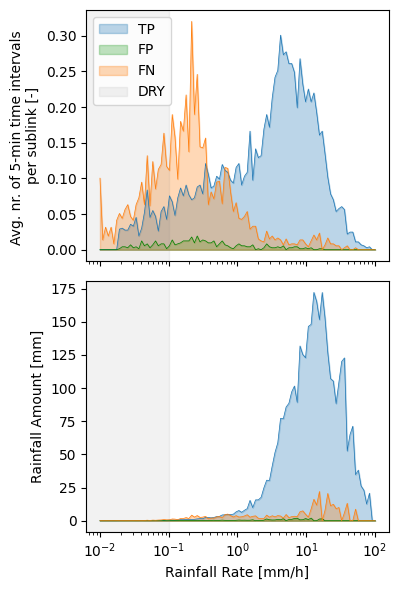

In [27]:
fig, axs = plt.subplots(
    2,
    1,
    figsize=(4, 6),
    dpi=100,
    sharex=True,
)
x = np.logspace(-2, 2, num=100, endpoint=True, base=10.0, dtype=None, axis=0)

ds_cmls_size = ds_cmls_5m.sizes.get("sublink_id") * ds_cmls_5m.sizes.get("cml_id")

axs[0].plot(
    x,
    (tp) / ds_cmls_size,
    color="C0",
    linewidth=0.5,
)
axs[0].fill_between(x, (tp) / ds_cmls_size, alpha=0.3, color="C0", label="TP")
axs[0].plot(
    x,
    (fp) / ds_cmls_size,
    color="green",
    linewidth=0.5,
)
axs[0].fill_between(x, (fp) / ds_cmls_size, alpha=0.3, color="C2", label="FP")
axs[0].plot(
    x,
    (fn) / ds_cmls_size,
    color="tab:orange",
    linewidth=0.5,
)
axs[0].fill_between(x, (fn) / ds_cmls_size, alpha=0.3, color="tab:orange", label="FN")

axs[1].plot(
    x,
    (tp) * x / 12,
    color="C0",
    linewidth=0.5,
)
axs[1].fill_between(x, (tp) * x / 12, alpha=0.3, color="C0", label="TP")
axs[1].plot(
    x,
    (fp) * x / 12,
    color="green",
    linewidth=0.5,
)
axs[1].fill_between(
    x, (fp) * x / 12, alpha=0.3, color="green", label="FP"
)
axs[1].plot(
    x,
    (fn) * x / 12,
    color="tab:orange",
    linewidth=0.5,
)
axs[1].fill_between(x, (fn) * x / 12, alpha=0.3, color="tab:orange", label="FN")

plot_thr = 0.1
axs[0].set_xscale("log")
axs[0].axvspan(0, plot_thr, alpha=0.1, color="grey", label="DRY")
axs[1].axvspan(0, plot_thr, alpha=0.1, color="grey")

axs[0].set_ylabel("Avg. nr. of 5-min time intervals \nper sublink [-]")
# axs[0].set_xlabel('Rainfall Rate [mm/h]')
axs[1].set_ylabel("Rainfall Amount [mm]")
axs[1].set_xlabel("Rainfall Rate [mm/h]")

axs[0].legend()
plt.tight_layout()
plt.show()

In [ ]:
tp

In [28]:
# we use mask instead of .where because the object is a numpy array and not an xarray object
tp_mask = np.logical_and(cmls_flattened >= threshold, radar_flattened >= threshold)
tp, _ = np.histogram(
    cmls_flattened[tp_mask],
    bins=np.linspace(0.01, 100, 101)
)

fp_mask = np.logical_and(cmls_flattened >= threshold, radar_flattened < threshold)
fp, _ = np.histogram(
    cmls_flattened[fp_mask],
    bins=np.linspace(0.01, 100, 101)
)

fn_mask = np.logical_and(cmls_flattened < threshold, radar_flattened >= threshold)
fn, _ = np.histogram(
    radar_flattened[fn_mask],
    bins=np.linspace(0.01, 100, 101)
)

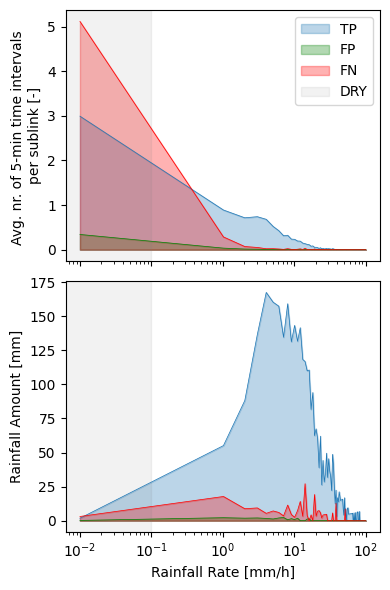

In [29]:
fig, axs = plt.subplots(
    2,
    1,
    figsize=(4, 6),
    dpi=100,
    sharex=True,
)
x = np.linspace(0.01, 100, 100)

ds_cmls_size = ds_cmls_5m.sizes.get("sublink_id") * ds_cmls_5m.sizes.get("cml_id")

t = axs[0].plot(
    x,
    (tp) / ds_cmls_size,
    color="C0",
    linewidth=0.5,
)
tt = axs[0].fill_between(x, (tp) / ds_cmls_size, alpha=0.3, color="C0", label="TP")
axs[0].plot(
    x,
    (fp) / ds_cmls_size,
    color="green",
    linewidth=0.5,
)
axs[0].fill_between(x, (fp) / ds_cmls_size, alpha=0.3, color="green", label="FP")
axs[0].plot(
    x,
    (fn) / ds_cmls_size,
    color="red",
    linewidth=0.5,
)
axs[0].fill_between(x, (fn) / ds_cmls_size, alpha=0.3, color="red", label="FN")

axs[1].plot(
    x,
    (tp) * x / 12,
    color="C0",
    linewidth=0.5,
)
axs[1].fill_between(x, (tp) * x / 12, alpha=0.3, color="C0", label="TP")
axs[1].plot(
    x,
    (fp) * x / 12,
    color="green",
    linewidth=0.5,
)
axs[1].fill_between(
    x, (fp) * x / 12, alpha=0.3, color="green", label="FP"
)
axs[1].plot(
    x,
    (fn) * x / 12,
    color="red",
    linewidth=0.5,
)
axs[1].fill_between(x, (fn) * x / 12, alpha=0.3, color="red", label="FN")

plot_thr = 0.1
axs[0].set_xscale("log")
axs[0].axvspan(0, plot_thr, alpha=0.1, color="grey", label="DRY")
axs[1].axvspan(0, plot_thr, alpha=0.1, color="grey")


axs[0].set_ylabel("Avg. nr. of 5-min time intervals \nper sublink [-]")
# axs[0].set_xlabel('Rainfall Rate [mm/h]')
axs[1].set_ylabel("Rainfall Amount [mm]")
axs[1].set_xlabel("Rainfall Rate [mm/h]")

axs[0].legend()
plt.tight_layout()
plt.show()

In [ ]:
t[0]

In [ ]:
tp-tr